In [1]:
import re
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from torch_geometric.data import Data, DataLoader, DenseDataLoader as DenseLoader
from torch_geometric.data import InMemoryDataset
import torch_geometric.transforms as T
import networkx as nx
from collections import Counter

from gumbel_softmax import DiffPool 



In [2]:
# !!! load data
with open(r'./data/patient_gumbel_test.pickle', 'rb') as handle:
        patient_dict= pickle.load(handle)
        
class PatientDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(PatientDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []
                                             
    @property
    def processed_file_names(self):
        return ['patient.dataset']

    def download(self):
        pass
    
    def process(self):
        
        data_list = []
        node_labels_dict = {'Tumor': 0, 'Stroma': 1, 'TIL1': 2, 'TIL2': 3, 'NK': 4, 'MP': 5}
#         node_labels_dict = {'TIL':0, 'Tumor': 1, 'Stroma': 2}
        class_num = len(node_labels_dict)
        
        for idx, v in enumerate(patient_dict.values()):
            for G in v:
                node_features = torch.LongTensor([node_labels_dict[i] for i in 
                                list(nx.get_node_attributes(G, 'cell_types').values())]).unsqueeze(1)
                x = torch.zeros(len(G.nodes), class_num).scatter_(1, node_features, 1)
                y = torch.LongTensor([idx])
                edges = sorted([e for e in G.edges] + [e[::-1] for e in G.edges])
                edge_index = torch.tensor([[e[0] for e in edges],
                                           [e[1] for e in edges]], dtype=torch.long)
                data = Data(x=x, edge_index=edge_index, y=y)
                data_list.append(data)
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

def get_dataset(path, sparse=False):
    
    dataset = PatientDataset(path)
    if not sparse:
        max_num_nodes = 0
        for data in dataset:
            max_num_nodes = max(data.num_nodes, max_num_nodes)

        if dataset.transform is None:
            dataset.transform = T.ToDense(max_num_nodes)
        else:
            dataset.transform = T.Compose(
                [dataset.transform, T.ToDense(max_num_nodes)])

    return dataset

dataset_dict = {}
path = './data/patient_gumbel_onlytest'
dataset_dict['gumbel2_5'] = get_dataset(path, sparse=False)



In [3]:
def plot_loss_acc(filename, xvalues):
    with open(filename) as f:
        contents = f.readlines()
    # you may also want to remove whitespace characters like `\n` at the end of each line
    dic = {}
    for line in contents:
        if "Num" in line:
            param = line.strip()
            dic[param] = [[], [], [], []]
        if "Train Loss" in line:
            loss = float(re.findall("Train Loss: ([0-9.]+)", line)[0])
            acc = float(re.findall("Train Accuracy: ([0-9.]+)", line)[0])
            dic[param][0].append(loss)
            dic[param][1].append(acc)
        if 'Val Loss' in line:
            loss = float(re.findall("Val Loss: ([0-9.]+)", line)[0])
            acc = float(re.findall("Val Accuracy: ([0-9.]+)", line)[0])
            dic[param][2].append(loss)
            dic[param][3].append(acc)
            
    for key, val in dic.items():
        fig, (ax_loss, ax_acc) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 12))
        # plot loss
        ax_loss.set_title("Loss")
        length = len(val[0])
        if length > 2000:
            ax_loss.plot(range(1, length+1)[0::10], val[0][0::10], label='training')
            ax_loss.plot(xvalues[0::10], val[2][0::10], c='r', label='validation')
            ax_loss.legend()
        else: 
            ax_loss.plot(range(1, length+1), val[0], label='training')
            ax_loss.plot(xvalues, val[2], c='r', label='validation')
            ax_loss.legend()
        
        # plot accuracy
        ax_acc.set_title("Accuracy")
        length = len(val[1])
        if length > 2000:
            ax_acc.plot(range(1, length+1)[0::10], val[1][0::10], label='training')
            ax_acc.plot(xvalues[0::10], val[3][0::10], c='r', label='validation')
            ax_acc.legend()
        else:
            ax_acc.plot(range(1, length+1), val[1], label='training')
            ax_acc.plot(xvalues, val[3], c='r', label='validation')
            ax_acc.legend()

In [19]:
# save on gpu, load on cpu
# load model parameters 
def load_model(dir_path, params_name, m, num_patches=5, ratio=0.05, plot=True, ge=False, \
               total=20, hard=False, drop_lin2=True, decay_rate=1):
    device = torch.device('cpu')
    model = m(dataset, 5, 64, num_patches=num_patches, ratio=ratio, plot=plot, \
              ge=ge, total=total, hard=hard, decay_rate=decay_rate)
    params = torch.load(dir_path+params_name, map_location=device)
    # fix a problem thhat pre-training model contains lin2 (defined but not included in the computational graph)
    if drop_lin2:
        params.pop('lin2.weight', None)
        params.pop('lin2.bias', None)
    model.load_state_dict(params)
    return model


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def cal_cfm_LogSoftmax_z(model, loader, initial_temp=0.5, total=20):
        
    model.eval()
    matrix = []
    matrix_hard = []
    Z = []
    y_true = []
    y_pred = []
    y_pred_hard = []
    logits = []
    
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            (out, out_hard), z, q_y = model(data, initial_temp)
            matrix.append(out.numpy())
            matrix_hard.append(out_hard.numpy())
            Z.append(z.numpy())
            logits.append(q_y.numpy())
            
            pred, pred_hard = out.max(1)[1], out_hard.max(1)[1]
            y_pred += pred.tolist() 
            y_pred_hard += pred_hard.tolist()
            
            len_ = len(data.y)
            indices = [i for i in range(0, len_, total)]
            y_true += data.y[indices].view(-1).tolist()
       
    matrix, matrix_hard = np.concatenate(matrix), np.concatenate(matrix_hard)
    
    
    Z, logits = np.concatenate(Z), np.concatenate(logits)
    cfm, cfm_hard = confusion_matrix(y_true, y_pred), confusion_matrix(y_true, y_pred_hard)
    return (cfm, cfm_hard), (matrix, matrix_hard), Z, logits


def shuffle(m=20):
#     random.seed(123)
    indices = []
    for i in range(num_patients):
        tmp = [j for j in range(i*m, i*m+m)]
        random.shuffle(tmp)
        indices += tmp
    return indices


def cal_mean_cfm_acc(dir_path, initial_temp, annealing_rate, lower_bound, epoch, repeat=100, ratio=0.05, \
                     num_patches=1, hard_train=False, plot=True, ge=False, total=10, hard=False, decay_rate=1):
    iteration = epoch - 1 if epoch != 0 else epoch
    temp = np.maximum(initial_temp * np.exp(-annealing_rate * iteration), lower_bound)
    params_name = 'params_epoch{}.pt'.format(epoch)
    model = load_model(dir_path, params_name, DiffPool, ratio=ratio, num_patches=num_patches, \
                       plot=plot, ge=ge, total=total, hard=hard, decay_rate=decay_rate)
    cfm_mean = np.zeros((num_patients, num_patients), dtype=int)
    acc_both, acc_one, acc_none = 0, 0, 0
    
    random.seed(123)
    for _ in range(repeat):
        indices = shuffle(m=total)
        gt = np.reshape(indices, (num_patients, total))
        gt[np.where(gt==np.max(gt, axis=1, keepdims=True))] = -1
        gt[np.where(gt==np.max(gt, axis=1, keepdims=True))] = -1
        gt[:] = np.where(gt == -1, 1, 0)
        data_loader = DenseLoader(dataset[indices], batch_size, shuffle=False)
        (cfm, cfm_hard), (matrix, matrix_hard), Z, logits = cal_cfm_LogSoftmax_z(model, data_loader, \
                                                initial_temp=temp, total=total)
        if hard_train:
            cfm_mean += cfm_hard
        else:
            cfm_mean += cfm
        Z_hard = (Z == Z.max(axis=2, keepdims=True)).astype(int)
        preds = Z_hard.sum(axis=1)
        preds[np.where(preds == 2)] = 1
        match_num = Counter((gt * preds).sum(axis=1))
        acc_both += match_num.get(2, 0) / num_patients
        acc_one += match_num.get(1, 0) / num_patients
        acc_none += match_num.get(0, 0) / num_patients
    return cfm_mean / repeat, acc_both / repeat, acc_one / repeat, acc_none / repeat


def plot_cfm_LogSoftmax(cfm):
    sns.set(font_scale=1.3)
    fig, ax = plt.subplots(1, 1, figsize = (8, 7))
    
    df_cm = pd.DataFrame(cfm, range(1, cfm.shape[0]+1), range(1, cfm.shape[0]+1))
    sns.heatmap(df_cm, cmap=plt.cm.Blues, annot=True, annot_kws={"size": 16}, ax=ax)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('confusion matrix')


In [5]:
batch_size = 50
num_patients = 10
total = 5
num_patches = 2


initial_temp = 10
annealing_rate = 0.01
lower_bound = 0.5
dataset = dataset_dict['gumbel2_5']


# max add

## soft version

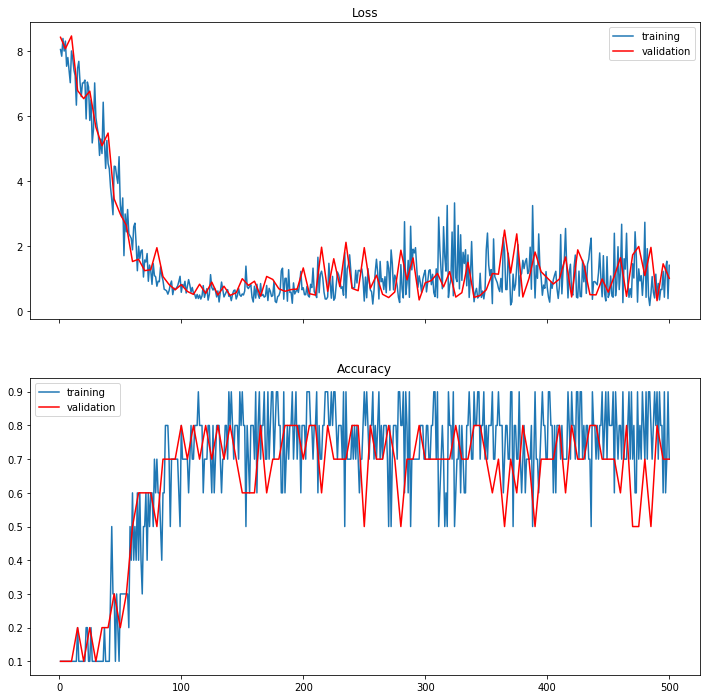

In [6]:
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel2_5-max-soft-add/'
plot_loss_acc(dir_path+'log_2021-04-10_18-03.txt', [1]+list(range(5, 501, 5)))
# plt.savefig('./img/g2551.png', dpi=300)

In [9]:
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel2_5-max-soft-add/'
epoch = 200
cfm_mean, acc_both, acc_one, acc_none = \
cal_mean_cfm_acc(dir_path, initial_temp, annealing_rate, lower_bound, epoch, repeat=100, \
                 ratio=0.05, num_patches=num_patches, hard_train=False, plot=True, ge=False, \
                 total=total, hard=True)


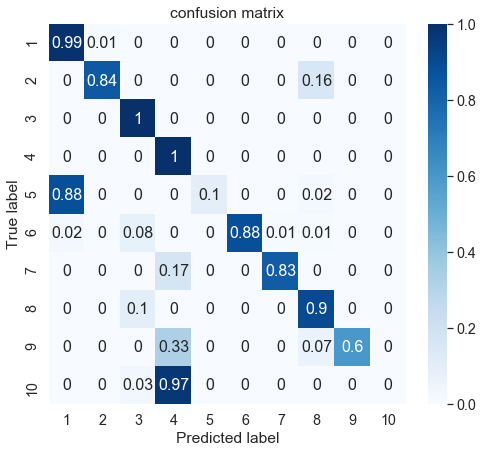

In [28]:
plot_cfm_LogSoftmax(cfm_mean)
plt.savefig('./img/max-soft-add.png', dpi=300)
plt.show()

In [21]:
print(acc_both, acc_one, acc_none)

0.5370000000000003 0.4599999999999998 0.0030000000000000005


## hard version

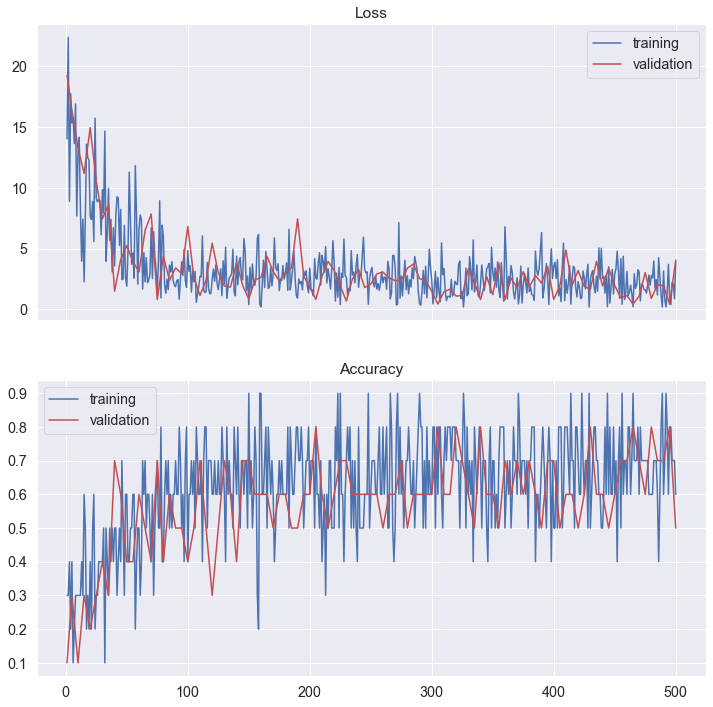

In [25]:
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel2_5-max-hard-add/'
plot_loss_acc(dir_path+'log_2021-04-10_18-48.txt', [1]+list(range(5, 501, 5)))

In [29]:
epoch = 200
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel2_5-max-hard-add/'
cfm_mean, acc_both, acc_one, acc_none = \
cal_mean_cfm_acc(dir_path, initial_temp, annealing_rate, lower_bound, epoch, repeat=100, \
                 ratio=0.05, num_patches=num_patches, hard_train=False, plot=True, ge=False, \
                 total=total, hard=True)


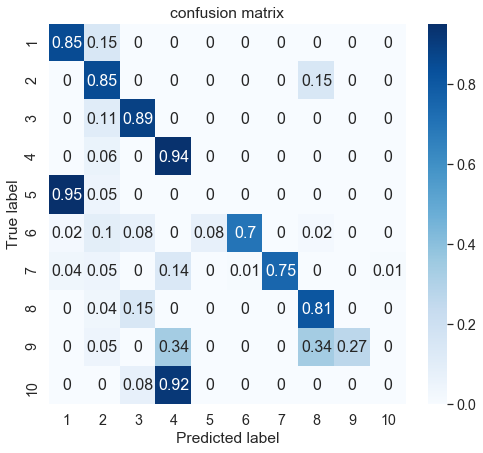

In [30]:
plot_cfm_LogSoftmax(cfm_mean)
plt.savefig('./img/max-hard-add.png', dpi=300)
plt.show()

In [31]:
print(acc_both, acc_one, acc_none)

0.37899999999999984 0.6050000000000003 0.016000000000000004


# max mean

## soft version

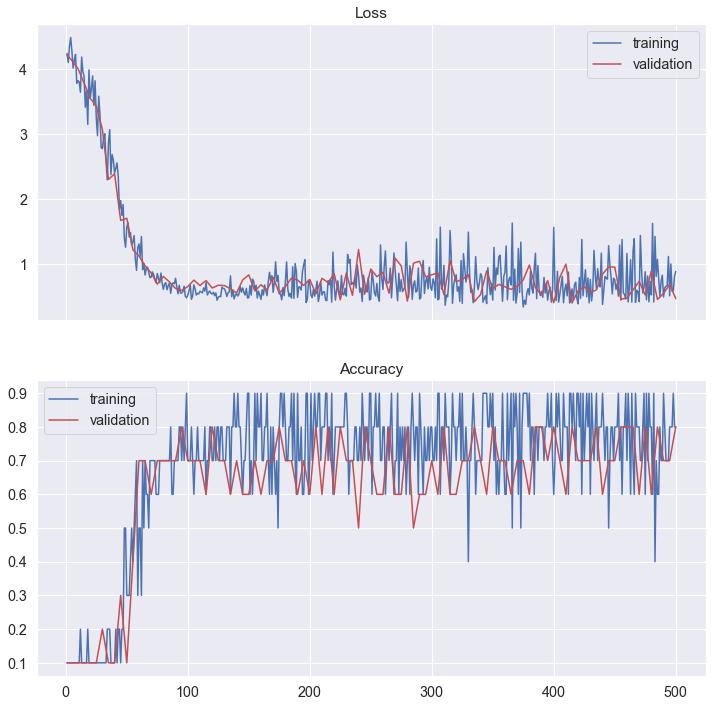

In [32]:
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel2_5-max-soft-mean/'
plot_loss_acc(dir_path+'log_2021-04-10_21-18.txt', [1]+list(range(5, 501, 5)))

In [33]:
epoch = 220
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel2_5-max-soft-mean/'
cfm_mean, acc_both, acc_one, acc_none = \
cal_mean_cfm_acc(dir_path, initial_temp, annealing_rate, lower_bound, epoch, repeat=100, \
                 ratio=0.05, num_patches=num_patches, hard_train=False, plot=True, ge=False, \
                 total=total, hard=True)

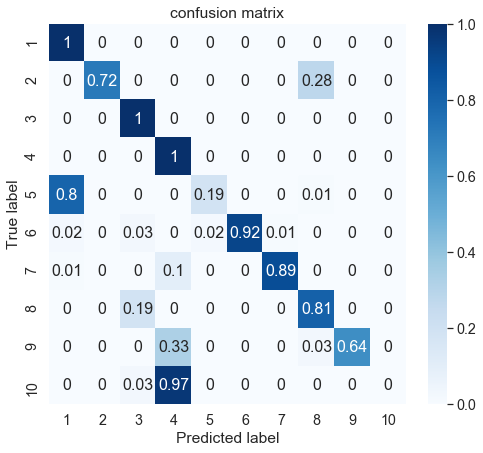

In [34]:
plot_cfm_LogSoftmax(cfm_mean)
plt.savefig('./img/max-soft-mean.png', dpi=300)
plt.show()

In [35]:
print(acc_both, acc_one, acc_none)

0.4909999999999999 0.5080000000000001 0.001


## hard version

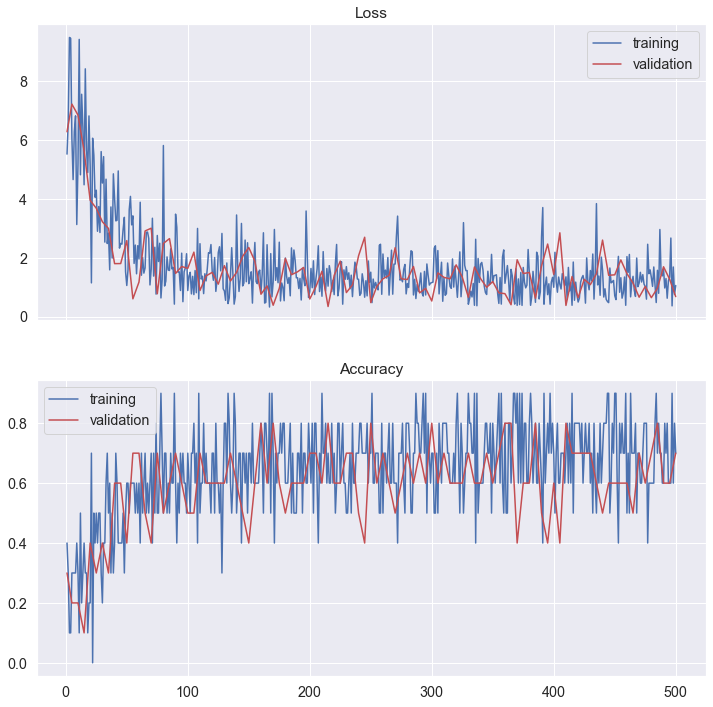

In [36]:
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel2_5-max-hard-mean/'
plot_loss_acc(dir_path+'log_2021-04-10_21-42.txt', [1]+list(range(5, 501, 5)))

In [36]:
epoch = 220
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel2_5-max-hard-mean/'
cfm_mean, acc_both, acc_one, acc_none = \
cal_mean_cfm_acc(dir_path, initial_temp, annealing_rate, lower_bound, epoch, repeat=100, \
                 ratio=0.05, num_patches=num_patches, hard_train=False, plot=True, ge=False, \
                 total=total, hard=True)

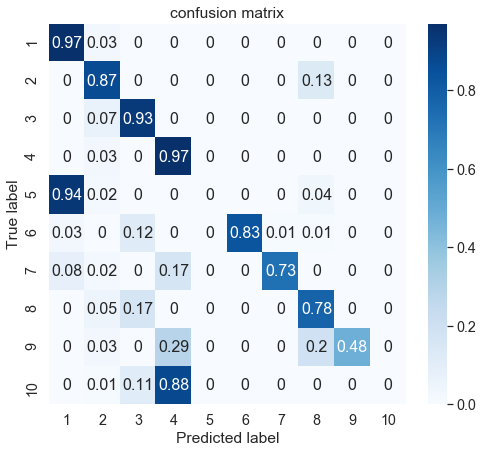

In [37]:
plot_cfm_LogSoftmax(cfm_mean)
plt.savefig('./img/max-hard-mean.png', dpi=300)
plt.show()

In [38]:
print(acc_both, acc_one, acc_none)

0.4329999999999998 0.5550000000000002 0.012


# max max

## soft version

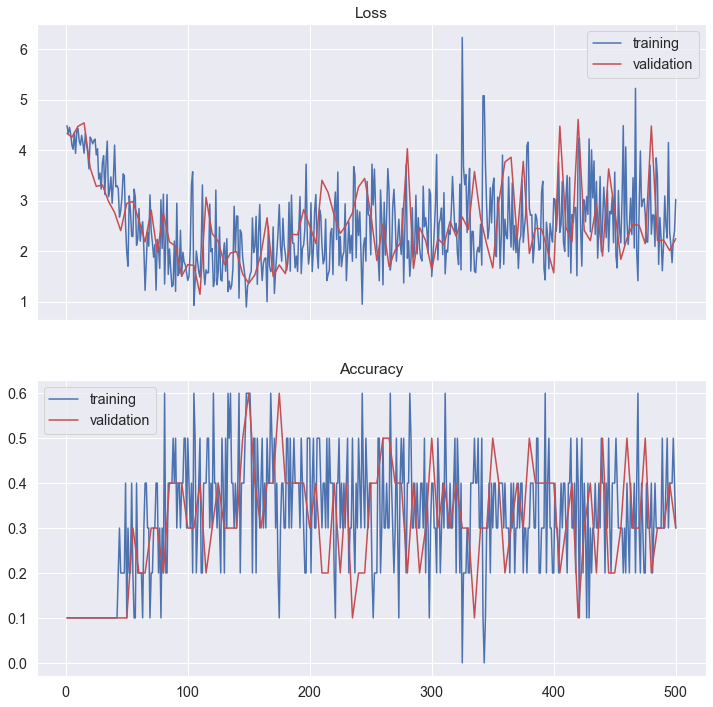

In [40]:
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel2_5-max-soft-max/'
plot_loss_acc(dir_path+'log_2021-04-10_22-05.txt', [1]+list(range(5, 501, 5)))

In [39]:
epoch = 140
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel2_5-max-soft-max/'
cfm_mean, acc_both, acc_one, acc_none = \
cal_mean_cfm_acc(dir_path, initial_temp, annealing_rate, lower_bound, epoch, repeat=100, \
                 ratio=0.05, num_patches=num_patches, hard_train=False, plot=True, ge=False, \
                 total=total, hard=True)

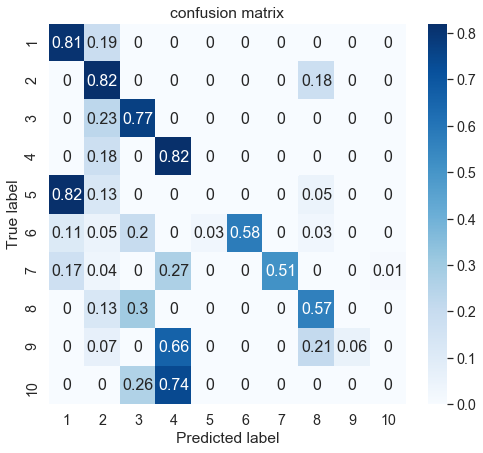

In [40]:
plot_cfm_LogSoftmax(cfm_mean)
plt.savefig('./img/max-soft-max.png', dpi=300)
plt.show()

In [41]:
print(acc_both, acc_one, acc_none)

0.2450000000000001 0.7200000000000002 0.03500000000000002


## hard version

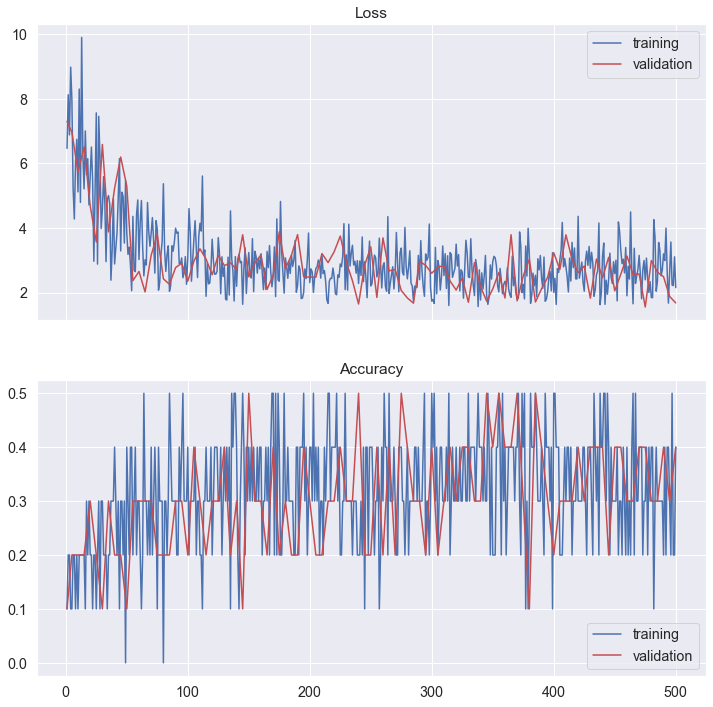

In [45]:
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel2_5-max-hard-max/'
plot_loss_acc(dir_path+'log_2021-04-10_22-28.txt', [1]+list(range(5, 501, 5)))

In [42]:
epoch = 160
dir_path = './data/DiffPool_gs_bs50_r005_joint/gumbel2_5-max-hard-max/'
cfm_mean, acc_both, acc_one, acc_none = \
cal_mean_cfm_acc(dir_path, initial_temp, annealing_rate, lower_bound, epoch, repeat=100, \
                 ratio=0.05, num_patches=num_patches, hard_train=False, plot=True, ge=False, \
                 total=total, hard=True)

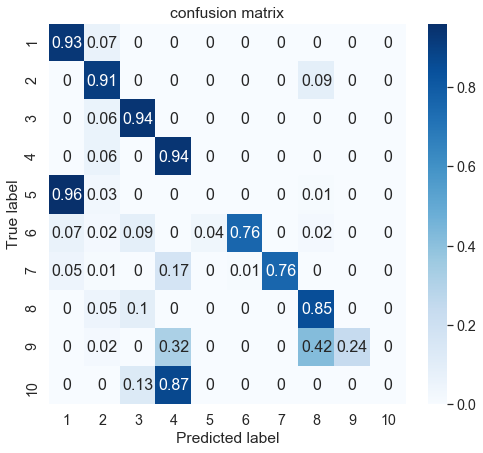

In [43]:
plot_cfm_LogSoftmax(cfm_mean)
plt.savefig('./img/max-hard-max.png', dpi=300)
plt.show()

In [44]:
print(acc_both, acc_one, acc_none)

0.25399999999999995 0.7360000000000001 0.009999999999999998
